In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../scripts")
from figures import figure_sizes

from multiprocessing import Pool
from scipy.sparse.linalg import eigs
from statfenics.utils import build_observation_operator, dolfin_to_csr
from swe import ShallowOne, ShallowOneLinear
from tqdm import tqdm

fe.set_log_level(50)

In [2]:
norm = np.linalg.norm

NX = 500
DT = 0.01
THETA = 0.6

# set the observation system
t_final = 200.
nt = np.int64(t_final / DT)
t_grid = np.arange(0., t_final, DT)
nt_skip = 100


def estimate_spectrum(A, n_eigen=128):
    return eigs(A, k=n_eigen, which="LM", return_eigenvectors=False)


def estimate_sp_cond(A):
    vals_upper = eigs(A, which="LM", return_eigenvectors=False)
    vals_lower = eigs(A, sigma=1e-8, return_eigenvectors=False)

    ew1 = abs(vals_upper)
    ew2 = abs(vals_lower)

    cond = ew1.max() / ew2.min()
    
    
def compute_spectrum(nu, n_eigen):
    swe = ShallowOne(
        control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
        params=dict(nu=nu, bump_centre=10))

    n_save = len([i for i in range(nt) if i % nt_skip == 0])
    spectrum = np.zeros((n_save, n_eigen))
    
    t = 0.
    i_save = 0
    for i in tqdm(range(nt)):
        t += swe.dt
        swe.solve(t, set_prev=False)

        if i % nt_skip == 0:
            J = fe.assemble(swe.rhs_derivative)
            J_scipy = dolfin_to_csr(J)

            spectrum[i_save, :] = estimate_spectrum(J_scipy, n_eigen)
            i_save += 1

        fe.assign(swe.du_prev, swe.du)

    return spectrum

In [3]:
pool = Pool(6)
nus = [1e-4, 1e-3, 1e-2, 1e-1, 1]
out = pool.starmap(compute_spectrum, [(nu, 10) for nu in nus])

  0%|                                                                               | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_1616675/4136706582.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[i_save, :] = estimate_spectrum(J_scipy, n_eigen)
  0%|                                                                     | 1/20000 [00:00<1:15:30,  4.41it/s]/tmp/ipykernel_1616675/4136706582.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[i_save, :] = estimate_spectrum(J_scipy, n_eigen)
  0%|                                                                     | 1/20000 [00:00<1:16:07,  4.38it/s]/tmp/ipykernel_1616675/4136706582.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrum[i_save, :] = estimate_spectrum(J_scipy, n_eigen)
  0%|                                                                     | 30/20000 [00:00<02:56, 112.88it/s]/tmp/ipykernel_1616675/413670658

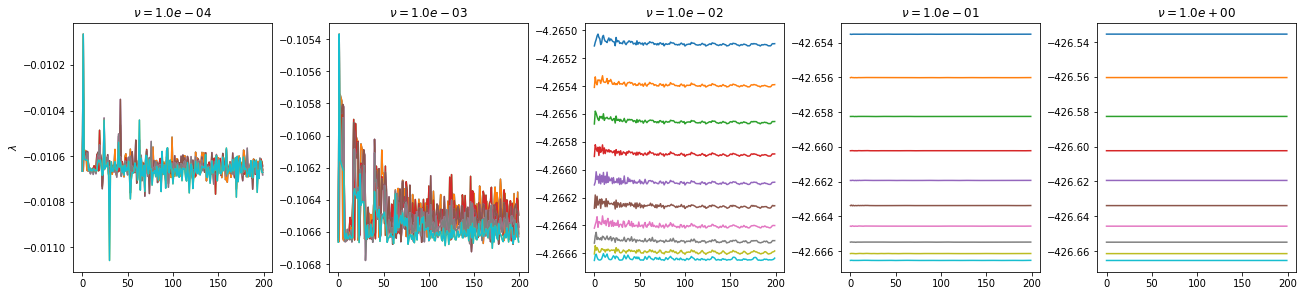

In [4]:
fig, axs = plt.subplots(1, len(out), 
                        constrained_layout=True,
                        figsize=(18, 4))
axs = axs.flatten()

for i, spectrum in enumerate(out):
    axs[i].plot(spectrum)
    axs[i].set_title(fr"$\nu = {nus[i]:.1e}$")
    
axs[0].set_ylabel(r"$\lambda$")
plt.show()